# GPT2 based - pure kaggle dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! pip install --quiet lightning
! pip install --quiet transformers
! pip install --quiet torch
! pip install --quiet accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.2/802.2 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 kB 5.8 MB/s eta 0:00:00


## no meta

In [ ]:
import torch
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification, GPT2Config, Trainer, TrainingArguments, DataCollatorWithPadding
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from torch.utils.data import Dataset, DataLoader

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
trainset = pd.read_csv('/content/drive/MyDrive/NUS_MSBA/BT5153_Final Group Project_Shared Folder/Data/kaggle_preprocessed.csv')

train_df, val_df = train_test_split(trainset, test_size=0.3)

In [ ]:
trainset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27275 entries, 0 to 27274
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   text                      27274 non-null  object 
 1   label                     27275 non-null  int64  
 2   %unique_word_total        27274 non-null  float64
 3   %stop_word_total          27274 non-null  float64
 4   mean_word_length          27274 non-null  float64
 5   mean_char_count_per_word  27274 non-null  float64
dtypes: float64(4), int64(1), object(1)
memory usage: 1.2+ MB


In [ ]:
train_df.head()

,text,label,%unique_word_total,%stop_word_total,mean_word_length,mean_char_count_per_word
23985,agree statement ideas important facts comes le...,1,0.341176,0.560784,4.396078,5.396078
3360,phones driving shouldnt phones driving could c...,0,0.358173,0.543269,4.233173,5.233173
17306,ever thought problem take best knowing made mi...,0,0.292517,0.560091,3.970522,4.968254
12455,dear senator florida writing argument favor ch...,0,0.583815,0.502890,4.618497,5.612717
26066,current political climate done lot shape way a...,1,0.742690,0.374269,5.421053,6.421053


In [ ]:
class TextDataset(Dataset):
    def __init__(self, tokenizer, texts, labels):
        self.tokenizer = tokenizer
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=512,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            truncation=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token

config = GPT2Config.from_pretrained('gpt2', num_labels=2)
config.pad_token_id = tokenizer.eos_token_id

model = GPT2ForSequenceClassification.from_pretrained('gpt2', config=config)
'''
# freeze all parameters initially
for param in model.parameters():
    param.requires_grad = False

# unfreeze the last two layers
# GPT-2 model uses model.transformer.h to store the transformer layers
for layer in model.transformer.h[-2:]:  # unfreezing the last two layers
    for param in layer.parameters():
        param.requires_grad = True
'''

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


'\n# freeze all parameters initially\nfor param in model.parameters():\n    param.requires_grad = False\n\n# unfreeze the last two layers\n# GPT-2 model uses model.transformer.h to store the transformer layers\nfor layer in model.transformer.h[-2:]:  # unfreezing the last two layers\n    for param in layer.parameters():\n        param.requires_grad = True\n'

In [ ]:
train_df['text'] = train_df['text'].fillna('')
val_df['text'] = val_df['text'].fillna('')

In [ ]:
train_dataset = TextDataset(tokenizer, train_df['text'].tolist(), train_df['label'].tolist())
val_dataset = TextDataset(tokenizer, val_df['text'].tolist(), val_df['label'].tolist())

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # number of training epochs
    per_device_train_batch_size=8,   # batch size for training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=50,
    evaluation_strategy="epoch"
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator
)

trainer.train()


Epoch,Training Loss,Validation Loss
1,0.001000,0.041420
2,0.000400,0.017808
3,0.000000,0.015001


TrainOutput(global_step=7161, training_loss=0.056958484070649976, metrics={'train_runtime': 7027.3519, 'train_samples_per_second': 8.15, 'train_steps_per_second': 1.019, 'total_flos': 1.4966032686907392e+16, 'train_loss': 0.056958484070649976, 'epoch': 3.0})

In [ ]:
model_path = '/content/drive/MyDrive/NUS_MSBA/BT5153_Final Group Project_Shared Folder/GPT2 based/GPT2based-kaggle-nometa'

trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

('/content/drive/MyDrive/NUS_MSBA/BT5153_Final Group Project_Shared Folder/GPT2based-kaggle-nometa/tokenizer_config.json',
 '/content/drive/MyDrive/NUS_MSBA/BT5153_Final Group Project_Shared Folder/GPT2based-kaggle-nometa/special_tokens_map.json',
 '/content/drive/MyDrive/NUS_MSBA/BT5153_Final Group Project_Shared Folder/GPT2based-kaggle-nometa/vocab.json',
 '/content/drive/MyDrive/NUS_MSBA/BT5153_Final Group Project_Shared Folder/GPT2based-kaggle-nometa/merges.txt',
 '/content/drive/MyDrive/NUS_MSBA/BT5153_Final Group Project_Shared Folder/GPT2based-kaggle-nometa/added_tokens.json')

In [ ]:
# load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_path = '/content/drive/MyDrive/NUS_MSBA/BT5153_Final Group Project_Shared Folder/GPT2 based/GPT2based-kaggle-nometa'
tokenizer = GPT2Tokenizer.from_pretrained(model_path)
model = GPT2ForSequenceClassification.from_pretrained(model_path)

model = model.to(device)

In [ ]:
testset = pd.read_csv('/content/drive/MyDrive/NUS_MSBA/BT5153_Final Group Project_Shared Folder/Data/new_essay_val_preprocessed.csv')

test_texts = testset['text'].tolist()
true_labels = testset['label'].values

In [ ]:
testset.head()

,text,label,sentence_variation,%stop_word_total,mean_word_length,%adjectives_total
0,sudan conflict human rights year civil war eru...,0,9.078032,0.425243,4.935922,0.082524
1,challenges american foreign service rebuilding...,0,10.024878,0.371251,5.815926,0.099276
2,end era nations habitually realized territoria...,0,23.250937,0.381433,5.890010,0.114026
3,promoting global regional security postcold wa...,0,14.830529,0.418864,5.314402,0.102434
4,mitigation crime honduras microfinance loans s...,0,10.491831,0.423156,5.239754,0.091189


In [ ]:
encoded_inputs = tokenizer(test_texts, padding=True, truncation=True, return_tensors="pt", max_length=512)

In [ ]:
test_dataset = torch.utils.data.TensorDataset(encoded_inputs['input_ids'], encoded_inputs['attention_mask'], torch.tensor(true_labels))
test_dataloader = DataLoader(test_dataset, batch_size=16)

In [ ]:
predictions = []
probabilities_list = []
model.eval()

GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (score): Linear(in_features=768, out_features=2, bias=False)
)

In [ ]:
for batch in test_dataloader:
    input_ids, attention_mask, labels = batch

    input_ids = input_ids.to('cuda' if torch.cuda.is_available() else 'cpu')
    attention_mask = attention_mask.to('cuda' if torch.cuda.is_available() else 'cpu')
    labels = labels.to('cuda' if torch.cuda.is_available() else 'cpu')

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=-1)
        predictions.extend(probabilities[:, 1].cpu().numpy())  # for class 1

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc

predicted_labels = [int(prob > 0.5) for prob in predictions]  # make class
accuracy = accuracy_score(true_labels, predicted_labels)
auroc = roc_auc_score(true_labels, predictions)

print(f"Accuracy: {accuracy}")
print(f"AUROC: {auroc}")

Accuracy: 0.825
AUROC: 0.9475


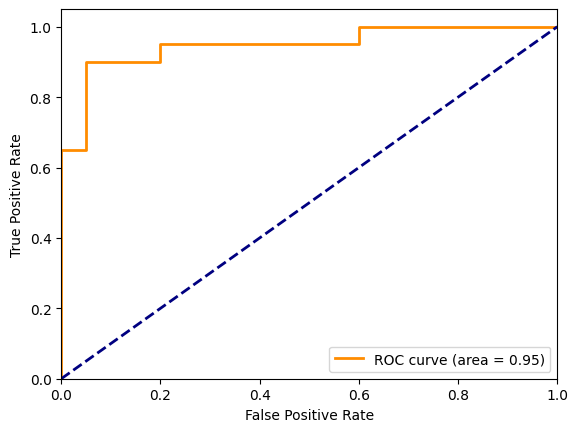

In [ ]:
import matplotlib.pyplot as plt

# calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(true_labels, predictions)

# calculate the AUROC
roc_auc = auc(fpr, tpr)

# plot the ROC curve
plt.figure()
lw = 2  # line width
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()


## with metafeatures

In [ ]:
import pandas as pd
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from sklearn.preprocessing import StandardScaler
import torch
from transformers import GPT2Model, GPT2Tokenizer, GPT2ForSequenceClassification, GPT2Config, Trainer, TrainingArguments, DataCollatorWithPadding
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from torch.utils.data import Dataset, DataLoader

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
trainset = pd.read_csv('/content/drive/MyDrive/NUS_MSBA/BT5153_Final Group Project_Shared Folder/Data/kaggle_preprocessed.csv')
trainset = trainset.dropna()

In [ ]:
trainset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27339 entries, 0 to 27339
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   text                27339 non-null  object 
 1   label               27339 non-null  int64  
 2   sentence_variation  27339 non-null  float64
 3   %stop_word_total    27339 non-null  float64
 4   mean_word_length    27339 non-null  float64
 5   %adjectives_total   27339 non-null  float64
dtypes: float64(4), int64(1), object(1)
memory usage: 1.5+ MB


In [ ]:
trainset.head()

,text,label,sentence_variation,%stop_word_total,mean_word_length,%adjectives_total
0,carfree cities become subject increasing inter...,1,7.063397,0.340870,6.083478,0.166957
1,car free cities carfree cities concept gaining...,1,7.512908,0.309942,6.298246,0.191033
2,sustainable urban future carfree cities emergi...,1,8.000000,0.302734,6.445312,0.197266
3,pioneering sustainable urban living era marked...,1,11.079196,0.333333,6.175337,0.190751
4,path sustainable urban living age rapid urbani...,1,11.405468,0.315068,6.207436,0.195695


In [ ]:
class CombinedModel(nn.Module):
    def __init__(self, gpt2_model_name, num_meta_features):
        super(CombinedModel, self).__init__()
        # load the pre-trained GPT-2 model
        self.gpt2 = GPT2Model.from_pretrained(gpt2_model_name)

        # define a simple feedforward network for meta-features
        self.meta_feature_ffn = nn.Sequential(
            nn.Linear(num_meta_features, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU()
        )

        # output layer that combines the features from GPT-2 and meta-features
        self.classifier = nn.Linear(self.gpt2.config.n_embd + 16, 2)

    def forward(self, input_ids, attention_mask, meta_features):
        # pass text through GPT-2
        gpt2_output = self.gpt2(input_ids=input_ids, attention_mask=attention_mask)
        text_embedding = gpt2_output.last_hidden_state[:, 0, :]

        # pass meta-features through the feedforward network
        meta_features_embedding = self.meta_feature_ffn(meta_features)

        # concatenate text and meta-features embeddings
        combined_embedding = torch.cat((text_embedding, meta_features_embedding), dim=1)

        # classify using the combined features
        logits = self.classifier(combined_embedding)

        return logits

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [ ]:

encodings = tokenizer(trainset['text'].tolist(), padding=True, truncation=True, return_tensors='pt')
labels = trainset['label'].values

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [ ]:
meta_features = trainset[['sentence_variation', '%stop_word_total', 'mean_word_length', '%adjectives_total']].values
scaler = StandardScaler()
meta_features = scaler.fit_transform(meta_features)

In [ ]:
# assume encodings is a dictionary with 'input_ids' and 'attention_mask'
input_ids_train, input_ids_val, attention_mask_train, attention_mask_val, train_meta_features, val_meta_features, train_labels, val_labels = train_test_split(
    encodings['input_ids'], encodings['attention_mask'], meta_features, labels, test_size=0.2
)

# after splitting, re-construct the encodings dictionaries
train_encodings = {'input_ids': input_ids_train, 'attention_mask': attention_mask_train}
val_encodings = {'input_ids': input_ids_val, 'attention_mask': attention_mask_val}

In [ ]:
class TextAndMetaDataset(Dataset):
    def __init__(self, encodings, meta_features, labels):
        self.encodings = {key: torch.tensor(val) for key, val in encodings.items()}
        self.meta_features = torch.tensor(meta_features, dtype=torch.float)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __getitem__(self, idx):
        item = {key: self.encodings[key][idx] for key in self.encodings}
        item['meta_features'] = self.meta_features[idx]
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
train_dataset = TextAndMetaDataset(train_encodings, train_meta_features, train_labels)
val_dataset = TextAndMetaDataset(val_encodings, val_meta_features, val_labels)


<ipython-input-12-8cc55d328310>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.encodings = {key: torch.tensor(val) for key, val in encodings.items()}


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=5, shuffle=False, num_workers=4, pin_memory=True)

model_meta = CombinedModel(gpt2_model_name='gpt2', num_meta_features=4)
model_meta.to(device)

optimizer = Adam(model_meta.parameters(), lr=5e-5)
loss_function = torch.nn.CrossEntropyLoss().to(device)

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

In [ ]:
from torch.cuda.amp import GradScaler, autocast


scaler = GradScaler()

num_epochs = 3

for epoch in range(num_epochs):
    model_meta.train()

    for batch in train_loader:
        optimizer.zero_grad()

        with autocast():  # Casts operations to mixed precision
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            meta_features = batch['meta_features'].to(device)
            labels = batch['labels'].to(device)

            outputs = model_meta(input_ids, attention_mask, meta_features)
            loss = loss_function(outputs, labels)

        scaler.scale(loss).backward()  # Scales the loss for mixed precision
        scaler.step(optimizer)
        scaler.update()

        # loss.backward()
        # optimizer.step()

    # evaluate on the validation set
    model_meta.eval()
    val_loss = 0
    val_accuracy = 0
    total_val_samples = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            meta_features = batch['meta_features'].to(device)
            labels = batch['labels'].to(device)

            outputs = model_meta(input_ids, attention_mask, meta_features)
            loss = loss_function(outputs, labels)

            val_loss += loss.item()
            predictions = outputs.argmax(dim=1)
            val_accuracy += (predictions == labels).sum().item()
            total_val_samples += labels.size(0)

    val_loss /= len(val_loader)
    val_accuracy /= total_val_samples
    print(f"Epoch {epoch+1}: Validation loss = {val_loss:.4f}, Accuracy = {val_accuracy:.4f}")


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1: Validation loss = 0.3140, Accuracy = 0.8716
Epoch 2: Validation loss = 0.2556, Accuracy = 0.8980
Epoch 3: Validation loss = 0.2306, Accuracy = 0.9089


In [ ]:
torch.save(model_meta, '/content/drive/MyDrive/NUS_MSBA/BT5153_Final Group Project_Shared Folder/GPT2 based/GPT2based-kaggle-withmeta.pth')


In [ ]:
model_meta = CombinedModel(gpt2_model_name='gpt2', num_meta_features=4)
model_meta = torch.load('/content/drive/MyDrive/NUS_MSBA/BT5153_Final Group Project_Shared Folder/GPT2 based/GPT2based-kaggle-withmeta.pth')
model_meta.to(device)

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

CombinedModel(
  (gpt2): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (meta_feature_ffn): Sequential(
    (0): Linear(in_features=4, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
  )
  (

In [ ]:
testset = pd.read_csv('/content/drive/MyDrive/NUS_MSBA/BT5153_Final Group Project_Shared Folder/Data/new_essay_val_preprocessed.csv')

In [ ]:
testset.head()

,text,label,sentence_variation,%stop_word_total,mean_word_length,%adjectives_total
0,sudan conflict human rights year civil war eru...,0,9.078032,0.425243,4.935922,0.082524
1,challenges american foreign service rebuilding...,0,10.024878,0.371251,5.815926,0.099276
2,end era nations habitually realized territoria...,0,23.250937,0.381433,5.890010,0.114026
3,promoting global regional security postcold wa...,0,14.830529,0.418864,5.314402,0.102434
4,mitigation crime honduras microfinance loans s...,0,10.491831,0.423156,5.239754,0.091189


In [ ]:
tokenized_test = tokenizer(testset['text'].tolist(), padding=True, truncation=True, return_tensors="pt")
scaler = StandardScaler()
test_meta_features = scaler.fit_transform(testset[['sentence_variation', '%stop_word_total', 'mean_word_length', '%adjectives_total']].values)

In [ ]:
test_meta_features = torch.tensor(test_meta_features, dtype=torch.float)
true_labels = torch.tensor(testset['label'].values, dtype=torch.long)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
test_dataset = TensorDataset(tokenized_test['input_ids'], tokenized_test['attention_mask'], test_meta_features, true_labels)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score

# ensure the model is in evaluation mode
model_meta.eval()

# lists to store targets and predictions
actuals = []
predictions = []  # This should be a list where tensor values will be appended
probabilities = []  # This should be a list where tensor values will be appended

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, meta_features, labels = [item.to(device) for item in batch]

        # Forward pass
        outputs = model_meta(input_ids, attention_mask, meta_features)
        outputs = torch.softmax(outputs, dim=1)  # Convert logits to probabilities
        _, predicted = torch.max(outputs, 1)

        # Store predictions and actual labels
        actuals.extend(labels.cpu().numpy())
        predictions.extend(predicted.cpu().numpy())  # Correctly extend with numpy array
        probabilities.extend(outputs[:, 1].cpu().numpy())  # Correctly extend with numpy array

# Calculate Accuracy
accuracy = accuracy_score(actuals, predictions)
print("Accuracy:", accuracy)

# Calculate AUROC
auroc = roc_auc_score(actuals, probabilities)
print("AUROC:", auroc)

Accuracy: 0.825
AUROC: 0.8825


## no meta with domain fine tune

In [3]:
import torch
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification, GPT2Config, Trainer, TrainingArguments, DataCollatorWithPadding
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, confusion_matrix
from torch.utils.data import Dataset, DataLoader

In [4]:
# load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = torch.load('/content/drive/MyDrive/NUS_MSBA/BT5153_Final Group Project_Shared Folder/models/GPT2/GPT2-kaggle-nometa.pth')

model = model.to(device)

In [5]:
finetuneset = pd.read_csv('/content/drive/MyDrive/NUS_MSBA/BT5153_Final Group Project_Shared Folder/Data/new_essay_train_preprocessed.csv')

train_df, val_df = train_test_split(finetuneset, test_size=0.2, random_state = 33)

In [ ]:
finetuneset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   text                60 non-null     object 
 1   label               60 non-null     int64  
 2   sentence_variation  60 non-null     float64
 3   %stop_word_total    60 non-null     float64
 4   mean_word_length    60 non-null     float64
 5   %adjectives_total   60 non-null     float64
dtypes: float64(4), int64(1), object(1)
memory usage: 2.9+ KB


In [6]:
class TextDataset(Dataset):
    def __init__(self, tokenizer, texts, labels):
        self.tokenizer = tokenizer
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=512,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            truncation=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


In [11]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token


In [12]:
train_dataset = TextDataset(tokenizer, train_df['text'].tolist(), train_df['label'].tolist())
val_dataset = TextDataset(tokenizer, val_df['text'].tolist(), val_df['label'].tolist())

In [13]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=15,             # number of training epochs
    per_device_train_batch_size=8,   # batch size for training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    evaluation_strategy="epoch"
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator
)

trainer.train()


Epoch,Training Loss,Validation Loss
1,No log,2.422336
2,1.516900,2.327102
3,1.516900,2.154566
4,1.222900,1.849165
5,0.960900,1.273563
6,0.960900,0.966108
7,0.633400,0.577863
8,0.633400,0.333234
9,0.222800,0.239940
10,0.177800,0.187251


TrainOutput(global_step=90, training_loss=0.5313601336804115, metrics={'train_runtime': 94.0889, 'train_samples_per_second': 7.652, 'train_steps_per_second': 0.957, 'total_flos': 188133660426240.0, 'train_loss': 0.5313601336804115, 'epoch': 15.0})

In [14]:
torch.save(model, '/content/drive/MyDrive/NUS_MSBA/BT5153_Final Group Project_Shared Folder/models/GPT2/GPT2-kaggle-finetune.pth')

In [ ]:
testset = pd.read_csv('/content/drive/MyDrive/NUS_MSBA/BT5153_Final Group Project_Shared Folder/Data/new_essay_val_preprocessed.csv')

test_texts = testset['text'].tolist()
true_labels = testset['label'].values

encoded_inputs = tokenizer(test_texts, padding=True, truncation=True, return_tensors="pt", max_length=512)

test_dataset = torch.utils.data.TensorDataset(encoded_inputs['input_ids'], encoded_inputs['attention_mask'], torch.tensor(true_labels))
test_dataloader = DataLoader(test_dataset, batch_size=16)

In [ ]:
predictions = []
probabilities_list = []
model.eval()

for batch in test_dataloader:
    input_ids, attention_mask, labels = batch

    input_ids = input_ids.to('cuda' if torch.cuda.is_available() else 'cpu')
    attention_mask = attention_mask.to('cuda' if torch.cuda.is_available() else 'cpu')
    labels = labels.to('cuda' if torch.cuda.is_available() else 'cpu')

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=-1)
        predictions.extend(probabilities[:, 1].cpu().numpy())  # for class 1

In [ ]:
predicted_labels = [int(prob > 0.5) for prob in predictions]  # make class
accuracy = accuracy_score(true_labels, predicted_labels)
auroc = roc_auc_score(true_labels, predictions)

print(f"Accuracy: {accuracy}")
print(f"AUROC: {auroc}")

# Accuracy: 0.925 AUROC: 0.96

Accuracy: 0.95
AUROC: 0.985


In [ ]:
deployset = pd.read_csv('/content/drive/MyDrive/NUS_MSBA/BT5153_Final Group Project_Shared Folder/Data/test_data_preprocessed.csv')

test_texts = deployset['text'].tolist()
true_labels = deployset['label'].values

encoded_inputs = tokenizer(test_texts, padding=True, truncation=True, return_tensors="pt", max_length=512)

test_dataset = torch.utils.data.TensorDataset(encoded_inputs['input_ids'], encoded_inputs['attention_mask'], torch.tensor(true_labels))
test_dataloader = DataLoader(test_dataset, batch_size=16)

In [ ]:
predictions = []
probabilities_list = []
model.eval()

for batch in test_dataloader:
    input_ids, attention_mask, labels = batch

    input_ids = input_ids.to('cuda' if torch.cuda.is_available() else 'cpu')
    attention_mask = attention_mask.to('cuda' if torch.cuda.is_available() else 'cpu')
    labels = labels.to('cuda' if torch.cuda.is_available() else 'cpu')

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=-1)
        predictions.extend(probabilities[:, 1].cpu().numpy())  # for class 1

In [ ]:
predicted_labels = [int(prob > 0.5) for prob in predictions]  # make class
accuracy = accuracy_score(true_labels, predicted_labels)
auroc = roc_auc_score(true_labels, predictions)
cm = confusion_matrix(true_labels, predicted_labels)

print(f"Accuracy of deploy test: {accuracy}")
print(f"AUROCof deploy test: {auroc}")
print("Confusion Matrix:")
print(cm)

Accuracy of deploy test: 0.58
AUROCof deploy test: 0.9856
Confusion Matrix:
[[25  0]
 [21  4]]


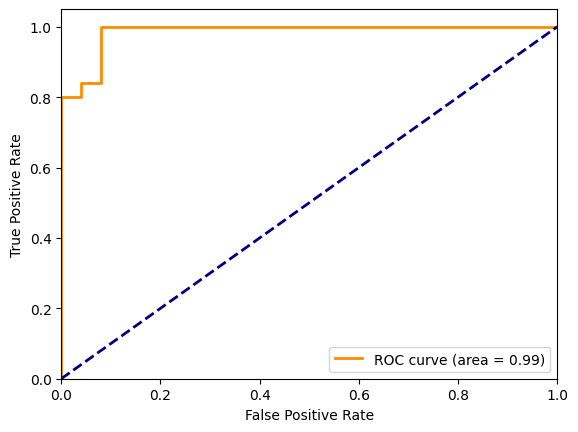

In [ ]:
import matplotlib.pyplot as plt

# calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(true_labels, predictions)

# calculate the AUROC
roc_auc = auc(fpr, tpr)

# plot the ROC curve
plt.figure()
lw = 2  # line width
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()


In [ ]:
# choose a better threshold
fpr, tpr, thresholds = roc_curve(true_labels, predictions)

# Calculate Youden's J statistic to identify the best threshold
j_scores = tpr - fpr
j_ordered = sorted(zip(j_scores, thresholds), key=lambda x: x[0], reverse=True)
best_threshold = j_ordered[0][1]

print(f"Optimal threshold: {best_threshold}")


Optimal threshold: 1.1669291097859968e-06


In [ ]:
predicted_labels = [int(prob > 0.01) for prob in predictions]
accuracy = accuracy_score(true_labels, predicted_labels)
auroc = roc_auc_score(true_labels, predictions)
cm = confusion_matrix(true_labels, predicted_labels)

print(f"Accuracy of deploy test: {accuracy}")
print(f"AUROCof deploy test: {auroc}")
print("Confusion Matrix:")
print(cm)

Accuracy of deploy test: 0.6
AUROCof deploy test: 0.9856
Confusion Matrix:
[[25  0]
 [20  5]]


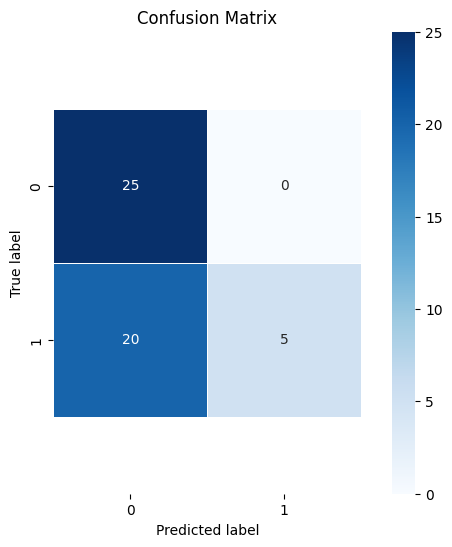

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the matplotlib figure
plt.figure(figsize=(8, 6))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', square=True, linewidths=.5)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim()  # discover the values for bottom and top
b += 0.5  # Add 0.5 to the bottom
t -= 0.5  # Subtract 0.5 from the top
plt.ylim(b, t)  # update the ylim(bottom, top) values

plt.show()
